# Planning and Learning with a Dyna-Q agent

**Due date : 26/02/2018**

**From : Julien Roy and David Kanaa**

In [1]:
from pycolab import ascii_art
from pycolab.prefab_parts import sprites as prefab_sprites
from pycolab.rendering import ObservationToFeatureArray

import os
import numpy as np
import pycolab

from tqdm import tqdm
from collections import namedtuple

from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction

In this assignment we explore how planning and learning can be combined in a single agent to be able to take advantage of a model of the environment while not entirely relying on it. Specifically, we implement the Dyna-Q algorithm and test it in two problems in which an agent has to find a goal location inside of a simple maze, but where the maze will change after a fixed number of iterations. The agent will then have to modify its current value function in order to adapt to the new environment. 

We will see in which circumstances a vanilla Dyna-Q agent succeeds and fails to complete this adaptation.

# Implementations

Here we show our impplementations of both the agent and the environment. The maze architecure can be simply defined with ascii code, and we can easily interact with it and simulate episodes using functions we have adapted from `pycolab`. Specifically, our `Maze` class is a wraper arounf a `pycolab.Engine` object that instanciates the game. Most of our use of pycolab is in section 3 (Environment mechanics). We define a general `changing_maze_experiment` that works for both BLOCKING_MAZE and SHORTCUT_MAZE problems.

### Environments

#### 1. Blocking Maze

In [2]:
BLOCKING_MAZE = [
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '######### #',
     '#         #',
     '#         #',
     '###########'],
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '# #########',
     '#         #',
     '#         #',
     '###########']
]

#### 2. Shortcut Maze

In [3]:
SHORTCUT_MAZE = [
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '# #########',
     '#         #',
     '#         #',
     '###########'],
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '# ####### #',
     '#         #',
     '#         #',
     '###########']
]

#### 3. Environment Mechanics

In [4]:
def make_game(art):
    """Builds and returns game."""
    return ascii_art.ascii_art_to_game(art, what_lies_beneath=' ', sprites={'P': PlayerSprite})

class PlayerSprite(prefab_sprites.MazeWalker):
    """A `Sprite` for our player.
    This `Sprite` ties actions to going in the four cardinal directions. If we
    reach a magical location, the agent receives a reward of 1 and the epsiode terminates.
    """

    def __init__(self, corner, position, character):
        """Inform superclass that the '#' delimits the walls."""
        super(PlayerSprite, self).__init__(corner, position, character, impassable='#')
    


    def update(self, actions, board, layers, backdrop, things, the_plot):
        del backdrop, things   # Unused in this application.

        # Apply motion commands.
        if actions == 0:    # walk upward
            self._north(board, the_plot)
        elif actions == 1:  # walk downward
            self._south(board, the_plot)
        elif actions == 2:  # walk leftward
            self._west(board, the_plot)
        elif actions == 3:  # walk rightward
            self._east(board, the_plot)

        # See if our agent is on the goal position
        if layers["G"][self.position]:
            the_plot.add_reward(1.0)
            the_plot.terminate_episode()
        else:
            the_plot.add_reward(0.0)

In [5]:
class Maze(object):
    def __init__(self, arts, start, goal):
        self.arts = arts
        self.index = 0
        
        self.START = start
        self.GOAL  = goal
    
    def _add_marker(self, art, marker, position):
        y, x = position
        tmp = list(art[y])
        tmp[x] = marker
        art[y] = "".join(tmp)
        return art
    
    def build(self):
        art = self.arts[self.index]
        art = self._add_marker(art, "P", self.START)  # add the player's position
        art = self._add_marker(art, "G", self.GOAL)  # add the goal's position
        self.game = make_game(art)
        return self
    
    def select(self, i):
        assert i < len(self.arts), "Index out of bounds. Should be between {} and {}".format(0, len(self.arts)-1)
        self.index = i
        return self
    
    def its_showtime(self):
        obs, reward, gamma = self.game.its_showtime()
        return obs, reward, gamma
    
    def play(self, action):
        obs, reward, gamma = self.game.play(action)
        return obs, reward, gamma
    
    @property
    def rows(self):
        return self.game.rows
    
    @property
    def cols(self):
        return self.game.cols
    
    @property
    def game_over(self):
        return self.game.game_over

In [6]:
class Recorder(object):
    def __init__(self, save_dir, obs, Q):
        
        self.save_dir = save_dir
        if not(os.path.exists(self.save_dir)):
            os.makedirs(self.save_dir)
        
        self.fig, self.ax = plt.subplots(1, 2, figsize=(4, 8))
        self.ax[0].axis("off")
        self.ax[1].axis("off")
        
        self.ax[0].set_title('Maze', fontweight='bold')
        self.ax[1].set_title('Max Q(s, :)', fontweight='bold')
        
        board = 80 * np.array(obs.layers['P'], dtype=np.float)
        board += 15 * np.array(obs.layers['#'], dtype=np.float)
        board += 50 * np.array(obs.layers['G'], dtype=np.float)
        self.im1 = self.ax[0].imshow(board)
        
        V = 255 * np.max(Q, axis=2)
        V = V.astype(np.int)
        self.im2 = self.ax[1].imshow(V)
        self.im2.set_cmap("inferno")
        
    def save_img(self, obs, Q, step):
        
        board = 80 * np.array(obs.layers['P'], dtype=np.float)
        board += 15 * np.array(obs.layers['#'], dtype=np.float)
        board += 50 * np.array(obs.layers['G'], dtype=np.float)
        
        V = 255 * np.max(Q, axis=2)
        V = V.astype(np.int)
        
        self.im1.set_data(board)
        self.im2.set_data(V)
        self.im2.set_clim(vmin=V.min(), vmax=V.max())
        
        self.fig.savefig(plt.savefig(os.path.join(self.save_dir, "{}.png".format(step)), bbox_inches='tight'))

### Dyna-Q Algorithm

In [7]:
class SimpleModel(object):
    def __init__(self):
        """
        self._mapping: maps previously seen state_action_pairs to their next_state and reward 
        """
        self._mapping = dict()
    
    def add_transition(self, state, action, next_state, reward):
        """
        sate: list of int coordinates [x, y]
        action: int
        next_state: list of int coordinates [x, y]
        reward: float
        """
        # If state has never been visited, it is added to the model
        if state not in self._mapping.keys():
            self._mapping[state] = dict()
        
        # Adds the reward and next_state resulting from state_action_pair to the model
        self._mapping[state][action] = (reward, next_state)
    
    def sample(self):
        """
        return: sampled state-action pair with their corresponding next_state and reward
        """
        # Samples a state among the previously visited states
        state_index = np.random.choice(range(0, len(self._mapping.keys())))
        sampled_state = list(self._mapping)[state_index]
        
        # Samples an action among the previously selected actions for the sampled_state
        action_index = np.random.choice(range(0, len(self._mapping[sampled_state].keys())))
        sampled_action = list(self._mapping[sampled_state])[action_index]
        
        # extracts the reward and next_state for the sampled state-action pair
        sampled_reward, sampled_next_state = self._mapping[sampled_state][sampled_action]
        
        return sampled_state, sampled_action, sampled_reward, sampled_next_state

In [8]:
class DynaQ(object):
    def __init__(self, gamma=0.95, epsilon=0.1, alpha=0.1, n_planning_steps=5, threshold=0.01):
        # discount factor
        self.gamma = gamma

        # probability for exploration
        self.epsilon = epsilon

        # step size
        self.alpha = alpha

        # n-step planning
        self.n_planning_steps = n_planning_steps
        
        # threshold to consider a state-action pair value as being better than another one
        self.threshold = threshold
        
    # action selection with epsilon-greedy scheme
    def _select_action(self, state, Q):
        
        # flips a coin with probability epsilon to have 1 ...
        if np.random.binomial(1, self.epsilon) == 1:
            # if it's the case randomly pick an action amongst ALL ACTIONS. (EXPLRATION)
            return np.random.randint(4)
        
        else:
            # otherwise, pick an action (at random) amongst ACTIONS NEAR MAXIMUM VALUE (if many) (EXPLOITATION)
            values = Q[state[0], state[1], :]
            return np.random.choice(np.where((np.max(values) - values) < self.threshold)[0])

    # tabular dyna-Q algorithm
    def apply(self, Q, model, game, global_steps, n_steps, record=False):
        
        # initializes the game object
        obs, reward, gamma = game.its_showtime()
        del gamma #unused
        
        # finds where our agent is on the map, this position is the agent's current_state
        position = np.array(obs.layers['P'])
        current_state = np.unravel_index(position.argmax(), position.shape)
        
        steps = 0
        
        if record:
            recorder = Recorder("imgs", obs, Q)
            current_global_step = global_steps + steps
            recorder.save_img(obs, Q, current_global_step)

        while not(game.game_over):

            steps += 1

            # chooses an action to execute according to epsilon-greedy scheme
            action = self._select_action(current_state, Q)

            # takes action (samples a next state and reward form the environment)
            obs, reward, gamma = game.play(action)
            del gamma # unused
            
            # finds where our agent is after having taken action, this position is the next_state
            position = np.array(obs.layers['P'])
            next_state = np.unravel_index(position.argmax(), position.shape)
            
            if record:
                current_global_step = global_steps + steps
                recorder.save_img(obs, Q, current_global_step)

            # Q-Learning update (with real experience)
            Q[current_state[0], current_state[1], action] += \
                self.alpha * (reward + self.gamma * np.max(Q[next_state[0], next_state[1], :]) -
                Q[current_state[0], current_state[1], action])

            # feed the model with experience (adds new newly discovered transition)
            model.add_transition(current_state, action, next_state, reward)

            # random sample n-step tabular Q-planning
            for t in range(self.n_planning_steps):
                sampled_state, sampled_action, sampled_reward, sampled_next_state = model.sample()
                
                # Q-Learning update (with simulated experience)
                Q[sampled_state[0], sampled_state[1], sampled_action] += \
                    self.alpha * (sampled_reward + self.gamma * np.max(Q[sampled_next_state[0], sampled_next_state[1], :]) -
                    Q[sampled_state[0], sampled_state[1], sampled_action])

            # updates the current_state
            current_state = next_state
            
            if steps > n_steps:
                break
                
        if record:
            plt.close(recorder.fig)
        
        return steps

### Changing Maze scenario

In [9]:
def changing_maze_experiment(maze_arts, params):

    # set up max steps
    n_steps = params.n_steps

    # track the cumulative rewards
    rewards = np.zeros((n_steps,))

    for run in tqdm(range(0, params.n_runs)):
        
        # instantiate dyna-Q algorithm
        agent = DynaQ(gamma=params.gamma, epsilon=0.1, alpha=params.alpha, n_planning_steps=5)
        
        # set up model
        model = SimpleModel()

        # track cumulative reward in current run
        rewards_ = np.zeros((n_steps,))
        
        # instantiate game
        maze = Maze(maze_arts, start=(6, 4), goal=(1, 9))
        game = maze.select(0).build()
        index = game.index

        # initialize state action values
        state_action_values = np.zeros((game.rows, game.cols, 4))

        steps = 0
        last_steps = steps
        while steps < n_steps:
            # play for an episode
            steps += agent.apply(state_action_values, model, game, steps, n_steps, params.record)

            # update cumulative rewards
            steps_ = min(steps, n_steps - 1)
            rewards_[last_steps : steps_] = rewards_[last_steps]
            rewards_[steps_] = rewards_[last_steps] + 1
            last_steps = steps
            
            
            if index < len(params.change_points) and steps > params.change_points[index]:
                # change maze
                game = maze.select(1).build()
                index = game.index
            else:
                # keep same maze (rebuild)                
                game = maze.build()
                index = game.index
        rewards += rewards_

    # averaging over runs
    rewards /= params.n_runs

    return rewards

# Experiments

### 1. Demos 

### Blocking Maze Demo

In [10]:
# parameters for experiments
Params = namedtuple("Params", ["n_steps", "n_runs", "change_points", "alpha", "gamma", "record"])
params = Params(n_steps=3000, n_runs=1, change_points=[1000, np.inf], alpha=0.5, gamma=0.8, record=True)

# run the experiments on both "blocking maze" and "shortcut maze"
np.random.seed(1234)
rewards_bm = changing_maze_experiment(BLOCKING_MAZE, params)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:52<00:00, 172.84s/it]


In [11]:
%matplotlib
all_images = sorted(os.listdir("imgs_BM"), key=lambda item: (int(item.split('.')[0]), item))
all_images_list = []

fig = plt.figure(figsize=(12,6))

for image in all_images:
    
    im = plt.imread(os.path.join("imgs_BM", image))
    anim_im = plt.imshow(im, animated=True)
    plt.axis('off')
    all_images_list.append([anim_im])

ani = animation.ArtistAnimation(fig, all_images_list, interval=40, blit=True, repeat_delay=1000)

HTML(ani.to_html5_video())

Using matplotlib backend: Qt5Agg


### Shortcut Maze Demo

In [12]:
%matplotlib inline
# parameters for experiments
Params = namedtuple("Params", ["n_steps", "n_runs", "change_points", "alpha", "gamma", "record"])
params = Params(n_steps=3000, n_runs=1, change_points=[1000, np.inf], alpha=0.5, gamma=0.8, record=True)

# run the experiments on both "blocking maze" and "shortcut maze"
np.random.seed(1234)
rewards_bm = changing_maze_experiment(SHORTCUT_MAZE, params)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:02<00:00, 182.59s/it]


In [13]:
%matplotlib
all_images = sorted(os.listdir("imgs_SM"), key=lambda item: (int(item.split('.')[0]), item))
all_images_list = []

fig = plt.figure(figsize=(12,6))

for image in all_images:
    
    im = plt.imread(os.path.join("imgs_SM", image))
    anim_im = plt.imshow(im, animated=True)
    plt.axis('off')
    all_images_list.append([anim_im])

ani = animation.ArtistAnimation(fig, all_images_list, interval=40, blit=True, repeat_delay=1000)

HTML(ani.to_html5_video())

Using matplotlib backend: Qt5Agg


### 2. Dyna-Q in Blocking Maze and Shortcut Maze

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:44<00:00,  1.49s/it]


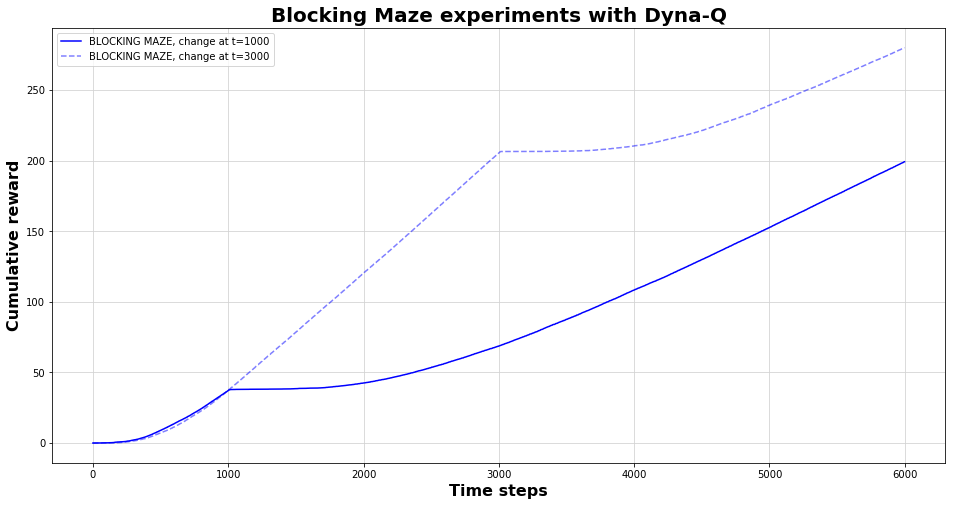

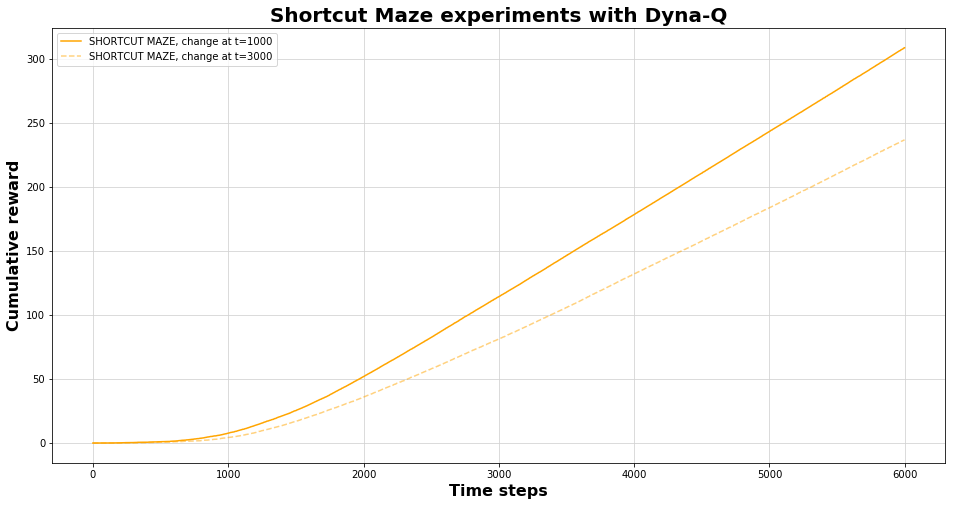

In [25]:
%matplotlib inline
# parameters for experiments
Params = namedtuple("Params", ["n_steps", "n_runs", "change_points", "alpha", "gamma", "record"])

# run the experiments on both "blocking maze" and "shortcut maze" when maze changes at t=1000
params = Params(n_steps=6000, n_runs=30, change_points=[1000, np.inf], alpha=0.5, gamma=0.8, record=False)
np.random.seed(1234)
rewards_bm_1000 = changing_maze_experiment(BLOCKING_MAZE, params)
np.random.seed(1234)
rewards_sm_1000 = changing_maze_experiment(SHORTCUT_MAZE, params)

# run the experiments on both "blocking maze" and "shortcut maze" when maze changes at t=3000
params = Params(n_steps=6000, n_runs=30, change_points=[3000, np.inf], alpha=0.5, gamma=0.8, record=False)
np.random.seed(1234)
rewards_bm_3000 = changing_maze_experiment(BLOCKING_MAZE, params)
np.random.seed(1234)
rewards_sm_3000 = changing_maze_experiment(SHORTCUT_MAZE, params)

# plot results
plt.figure(figsize=(16, 8))
plt.plot(rewards_bm_1000[:-1], color="blue", linestyle="-",  label="BLOCKING MAZE, change at t=1000")
plt.plot(rewards_bm_3000[:-1], color="blue", linestyle="--",  label="BLOCKING MAZE, change at t=3000", alpha=0.5)

plt.title('Blocking Maze experiments with Dyna-Q', fontsize=20, fontweight='bold')
plt.xlabel('Time steps', fontsize=16, fontweight='bold')
plt.ylabel('Cumulative reward', fontsize=16, fontweight='bold')
plt.legend(loc="best")
plt.grid(True, color="lightgrey")
plt.show()

# plot results
plt.figure(figsize=(16, 8))
plt.plot(rewards_sm_1000[:-1], color="orange", linestyle="-",  label="SHORTCUT MAZE, change at t=1000")
plt.plot(rewards_sm_3000[:-1], color="orange", linestyle="--",  label="SHORTCUT MAZE, change at t=3000", alpha=0.5)
#plt.axvline(3000, color="grey", linestyle="-", label="Change point at t=3000")

plt.title('Shortcut Maze experiments with Dyna-Q', fontsize=20, fontweight='bold')
plt.xlabel('Time steps', fontsize=16, fontweight='bold')
plt.ylabel('Cumulative reward', fontsize=16, fontweight='bold')
plt.legend(loc="best")
plt.grid(True, color="lightgrey")
plt.show()

### 3. Dyna-Q in Blocking Maze for different learning rate $\alpha$

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.33it/s]


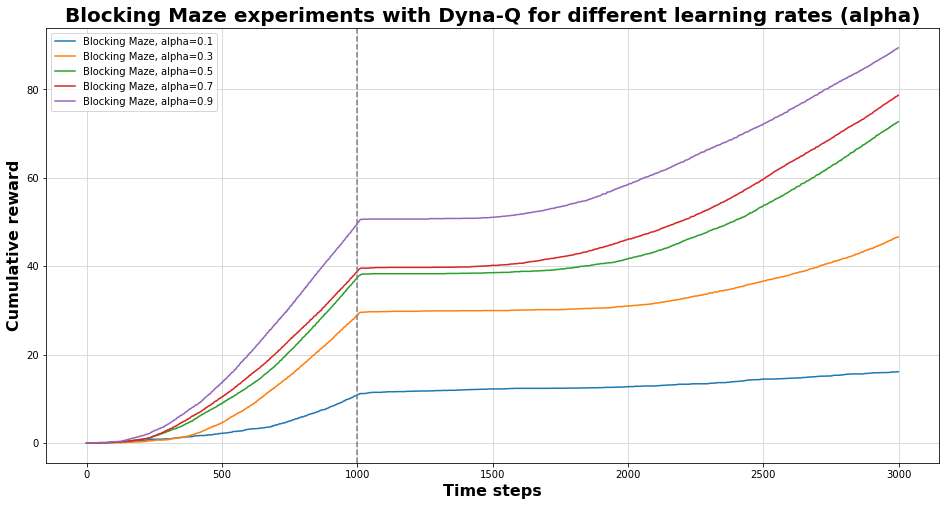

In [15]:
plt.figure(figsize=(16, 8))

for current_alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:

    np.random.seed(1234)
    # parameters for experiments
    Params = namedtuple("Params", ["n_steps", "n_runs", "change_points", "alpha", "gamma", "record"])
    params = Params(n_steps=3000, n_runs=30, change_points=[1000, np.inf], alpha=current_alpha, gamma=0.8, record=False)

    # run the experiments on both "blocking maze" and "shortcut maze"
    rewards_bm = changing_maze_experiment(BLOCKING_MAZE, params)

    # plot results
    plt.plot(rewards_bm[:-1], label="Blocking Maze, alpha={}".format(current_alpha))
    plt.title('Blocking Maze experiments with Dyna-Q for different learning rates (alpha)', fontsize=20, fontweight='bold')
    plt.xlabel('Time steps', fontsize=16, fontweight='bold')
    plt.ylabel('Cumulative reward', fontsize=16, fontweight='bold')
    plt.legend(loc="best")
    plt.grid(True, color="lightgrey")

plt.axvline(params.change_points[0], color="gray", linestyle="--", label="Change point")
plt.show()

### 4. Dyna-Q in Blocking Maze for different discounting factor $\gamma$

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.31it/s]


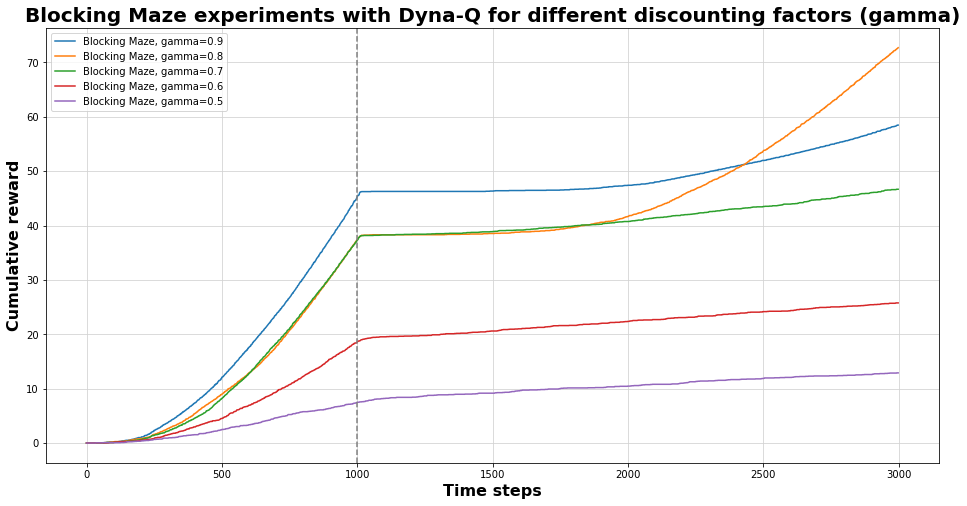

In [13]:
plt.figure(figsize=(16, 8))

for current_gamma in [0.9, 0.8, 0.7, 0.6, 0.5]:

    np.random.seed(1234)
    # parameters for experiments
    Params = namedtuple("Params", ["n_steps", "n_runs", "change_points", "alpha", "gamma", "record"])
    params = Params(n_steps=3000, n_runs=30, change_points=[1000, np.inf], alpha=0.5, gamma=current_gamma, record=False)

    # run the experiments on both "blocking maze" and "shortcut maze"
    rewards_bm = changing_maze_experiment(BLOCKING_MAZE, params)

    # plot results
    plt.plot(rewards_bm[:-1], label="Blocking Maze, gamma={}".format(current_gamma))
    plt.title('Blocking Maze experiments with Dyna-Q for different discounting factors (gamma)', fontsize=20, fontweight='bold')
    plt.xlabel('Time steps', fontsize=16, fontweight='bold')
    plt.ylabel('Cumulative reward', fontsize=16, fontweight='bold')
    plt.legend(loc="best")
    plt.grid(True, color="lightgrey")

plt.axvline(params.change_points[0], color="gray", linestyle="--", label="Change point")
plt.show()

# Discussion

**On sections 1 and 2 of experiments**

We can see that Dyna-Q is sucessfully adapting, given some transition time, to the new environment after the maze has been changed for the BLOCKING_MAZE problem. However, adapting to the new environment is a lot less certain when the environment changes for the better, like in the SHORTCUT_MAZE. This is because in the first case, the environment change makes it so that the current policy becomes totally inefficient, the agent is stuck behind the wall that has just been closed. Its state action values are therefore highly optimistic given that new environment, and it is able with further experience to lower the values of those states until they reach such a low value that they become not significantly better than the unknown states, at which point the agent is allowed to start exploring full time until it finds the new path (see demo in section 1 of experiments).

This adaptation does not always occur in SHORTCUT_MAZE because the environment change actually creates a faster way to the goal location, but because it does not prevent the agent from keep exploiting its current policy, the agent has to be incredibly lucky to discover the new path only with the randomly selected actions from its epsilon-greedy policy. In the experiment for which the environment changes at timestep t=1000, the agent usually hasn't completely reinforced its current path (it didn't go on every states yet) and therefore can still hope to discover the shortcut more often. Howver, in the experiment for which the the shortcut unlocks at t=3000, the left-path policy is now strongly established on pretty much every state of the environment, and there is very few hope that the agent will ever discover the shortcut (see the graph in section 2 of the experiments). Therefore, we can say that Dyna-Q is able to adapt when its environment gets more difficult by lowering its current state-action values, but can miss the opportunity to improve when its environment change for the better. To be able to seize those improving environment opportunities more reliably, we would need to implement a smarter exploration technique such as in Dyna-Q+, where the agent will more favorably choose state-action pairs from its model that it hasn't explored since a long time by giving it a *bonus reward* when choosing those options. This allows Dyna-Q+ to check if the environment has changed.

**On sections 3 and 4 of experiments**

Finally, we noticed that both the learning rate $\alpha$ and the discount factor $\gamma$ influenced the speed at which the agent would adapt after the maze change in the BLOCKING_MAZE problem. We performed experiment with different values for those hyperparameters to be able to choose a good candidate in both cases. Those results are presented in sections 3 and 4 of the experiments. For the learning rate, we chose to keep it to 0.5 because it allowed fo the same kind of slope after the maze change, even though learning rates at 0.7 and 0.9 cumulate more reward before the maze change. We found the relationship with the discount factor $\gamma$ to be particularly interesting. When this factor is too high, it takes a really long time after the maze change to lower the state-action values of the states behind the wall, and therefore takes more time until the agent can go back in full exploratory mode. However, as the factor decreases below 0.8 or 0.7, then it makes it harder for the agent to develop a strongly prefered trajectory since the values it chooses to increase keep fading out very quickly.

# How does Dyna-Q relate to Experience Replay ?

Experience replay is a general strategy in reinforcement learning that consists of storing previously encountered transitions $(s_t, a_t, r_{t+1}, s_{t+1})$ in a table (but do not store the associated state values), and to periodically sample some of those transitions to re-compute and re-apply an update based on them. The agent therefore alternates between applying updates based on real or simulated experience, and applying updates based on those replays, those *memories*.

Planning in Dyna-Q is not exactly the same thing as experience replay, at least in the general case. The Dyna-agent samples a set $(r_{t+1}, s_{t+1})$ from its model, given a $(s_t, a_t)$ previously encountered. Therefore, if the environment is stochastic, depending on the kind of model we are using, the returned reward and next state could be different than what we obtain by simply sampling among previously seen transitions $(s_t, a_t, r_{t+1}, s_{t+1})$ from a table. The case of value function approximation breaks even more the equivalence between Dyna-Q and experience replay as the weight vector used to transform the state feature vectors will be updated between alternating planning and learning sessions. However, if the environment is deterministic, then the model will always return the same next state and reward according to a given state-action pair, and in that context **planning in a Tabular Dyna-Q agent can be seen as a form of experience replay**.

The main advantage of using experience replay is to allow the agent to learn more from previous experience (rather than using the generated data only once and then discarding it). Learning many times over a single previously encountered transition is useful because the q-learning updates are incremental, and therefore do not converge after a single pass. This process is especially useful when generating experience is difficult or expansive. However, one must be careful not to overuse this strategy, because the previous transition on which it learns many times might have been collected out of extraordinary chance and not faithfully represent the dynamics of the environments. Also, experience learning is probably not a good strategy in a very dynamic environment, because for example past transitions might never occur again.

# Conclusion

Here are our main conclusions regarding this assignment :

* Dyna-Q is a simple yet powerful way of combining planning and learning.
* Given some time, Dyna-Q can adapt its policy when its environment deteriorates (blocking_maze), however, it will not necessarily update its policy for the better when a change in the environment that allows for a better solution occur after the agent is already confident in its policy (shortcut_maze). Dyna-Q+ could allow for such adaptation.
* The learning rate and discount factor strongly influence the time necessary for the agent to adapt after an environment change.
* Planning in Tabular Dyna-Q is equivalent to Experience Replay for a deterministic environment (although this equivalence do not hold for stochastic environment or value function approximation).
* Experience replay consists of simply re-updating the agent's value function based on previously seen transitions, and is a simple way to more fully use the experience gathered by the agent.